In [21]:
#Importing Required Modules or Libraries
import numpy as np
import cv2
import math
from scipy import ndimage
import PIL
import PIL.ImageOps
from PIL import Image
import sys
import time
import json
sys.path.insert(0,r'C:\Users\Engineer Singh\AppData\Local\Programs\Python\Python36\Lib\site-packages')
from mnist import MNIST
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
#Load Training Data And Testing Data
try:
    del train_images, train_labels
    del test_images, test_labels
    print("cleared loaded data")
except:
    pass

mndata = MNIST("D:\\Project to work\\Project data\\samples\\")
train_images, train_labels = mndata.load_training()
#print(mndata.display(images[0]))  #To display image
#print(labels[0])  #To display label of image

#Load Testing Data
test_images, test_labels = mndata.load_testing()
#print(mndata.display(test_images[0]))  #To display image
#print(test_labels[0])  #To display label of image

In [3]:
#convert Training And Testing Data into arrays
try:
    del X_train,y_train
    del X_test,y_test
    print('Clear previously loaded data.')
except:
    pass
X_train = np.array(train_images).astype(float)
y_train = np.array(train_labels)
X_test = np.array(test_images).astype(float)
y_test = np.array(test_labels)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (60000, 784)
Train labels shape:  (60000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


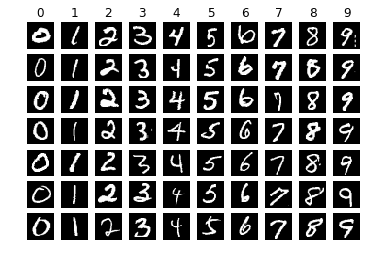

In [4]:
#Display Sample Trainig Data before preprocessing 
"""
by the way Trainig Data is already preprocessed but we again 
preprocess it so to extend this model to our own Testing data
"""
classes = [i for i in range(10)]
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape(28,28).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

In [22]:
#feature extraction

def extract_features(path):
    image = cv2.imread(path,0)
    img = Image.open(path)
    #plt.imshow(img)
    #plt.show()
    imagecopy = image.copy()
    edged = cv2.Canny(image, 10, 250)
    #cv2.imshow("Edges", edged)
    #cv2.waitKey(0)
    img = Image.fromarray(edged.astype('uint8'))
    #plt.imshow(img)
    #plt.show()
    #applying closing function 
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
    #cv2.imshow("Closed", closed)
    #cv2.waitKey(0)
    img = Image.fromarray(closed.astype('uint8'))
    #plt.imshow(img)
    #plt.show()
    l = []
    bb = []
    idx = 0
    #finding_contours 
    (I, cnts,_) = cv2.findContours(closed.copy(),
                cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bb = []
    for c in cnts:
        bb.append(cv2.boundingRect(c))
    bb.sort()
    #for i, contour in enumerate(cnts):
    #    x, y, w, h = cv2.boundingRect(contour) 
    #    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 1)
    #cv2.imshow("Output", image)
    #cv2.waitKey(0)
    charNo=0
    for i in bb:
        charNo += 1
        x,y,w,h = i
        new_img = image[y:y+h, x:x+w]
        img1 = Image.fromarray(new_img.astype('uint8'))
        l.append(process_img(img1))
        plt.subplot(10, 10, charNo)
        plt.imshow(img1)
    plt.show()
    return l

#process extracted features

def process_img(path):
    #img = Image.open(path)
    #plt.imshow(img)
    #plt.show()
    img = path
    img = img.convert('L')
    #plt.imshow(img)
    #plt.show()
    img = PIL.ImageOps.invert(img)
    #plt.imshow(img)
    #plt.show()
    ar = np.asarray(img)
    #print(ar.shape)
    v = ar.shape[0]
    h = ar.shape[1]
    m = abs(v-h)//2
    if v >= h:
        ar = np.hstack([ar, np.zeros((ar.shape[0], m))])
        ar = np.hstack([np.zeros((ar.shape[0], m)),ar])
    else:
        ar = np.vstack([ar, np.zeros((m,ar.shape[1]))])
        ar = np.vstack([np.zeros((m,ar.shape[1])),ar])
    #print(ar.shape)
    im = Image.fromarray(ar.astype('uint8'),mode='L')
    #plt.imshow(im,cmap='gray')
    #plt.show()
    im = im.resize((20,20),resample=PIL.Image.LANCZOS)
    #plt.imshow(im,cmap='gray')
    #plt.show()
    img = np.asarray(im)
    img = np.hstack([img, np.zeros((img.shape[0], 4))])
    img = np.hstack([np.zeros((img.shape[0], 4)),img])
    img = np.vstack([img, np.zeros((4,img.shape[1]))])
    img = np.vstack([np.zeros((4,img.shape[1])),img])
    #plt.imshow(img.astype('uint8'),cmap='gray')
    #plt.show()
    #print(img.shape)
    return img

In [23]:
# Function for Preprocessing of Image array
def process_arr(arr):
    or_shape = arr.shape
    arr = arr.reshape((28,28))
    iminv = Image.fromarray(arr.astype('uint8'))
    left,upper,right,lower = iminv.getbbox()
    aa = arr[upper:lower , left:right]
    ar = np.asarray(aa)
    #print(ar.shape)
    v = ar.shape[0]
    h = ar.shape[1]
    m = abs(v-h)//2
    if v >= h:
        ar = np.hstack([ar, np.zeros((ar.shape[0], m))])
        ar = np.hstack([np.zeros((ar.shape[0], m)),ar])
    else:
        ar = np.vstack([ar, np.zeros((m,ar.shape[1]))])
        ar = np.vstack([np.zeros((m,ar.shape[1])),ar])
    im = Image.fromarray(ar.astype('uint8'),mode='L')
    im = im.resize((20,20),resample=PIL.Image.LANCZOS)
    img = np.asarray(im)
    img = np.hstack([img, np.zeros((img.shape[0], 4))])
    img = np.hstack([np.zeros((img.shape[0], 4)),img])
    img = np.vstack([img, np.zeros((4,img.shape[1]))])
    img = np.vstack([np.zeros((4,img.shape[1])),img])
    return img.reshape(or_shape)

In [7]:
#Preprocessing of Image array
for i in range(len(X_train)):
    X_train[i] = process_arr(X_train[i])
for i in range(len(X_test)):
    X_test[i] = process_arr(X_test[i])

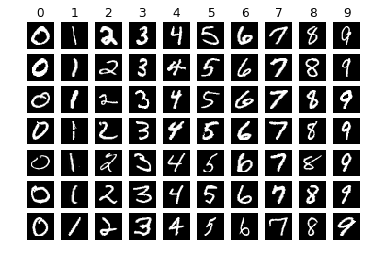

In [8]:
#Display Sample Trainig Data after preprocessing 
classes = [i for i in range(10)]
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape(28,28).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

In [9]:
#Subsampling Data for training , validation and Testing
num_training = 50000
num_validation = 10000
num_test = 10000
mask = list(range(num_training, num_training + num_validation))
X_val = X_train[mask]
y_val = y_train[mask]
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
    
# Normalize the data: subtract the mean image
mean_image = np.mean(X_train, axis = 0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (50000, 784)
Train labels shape:  (50000,)
Validation data shape:  (10000, 784)
Validation labels shape:  (10000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


In [24]:
#Neural Network Class
class TwoLayerNet(object):
    
    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
    def set_params(self,W1,b1,W2,b2):
        try:
            del self.params
        except:
            pass
        self.params = {}
        self.params['W1'] = W1
        self.params['b1'] = b1
        self.params['W2'] = W2
        self.params['b2'] = b2
    def loss(self, X, y=None, reg=0.0):
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        scores = None
        # Using ReLUs as the Activation Function
        H1 = np.maximum(0, np.dot(X, W1) + b1)
        H2 = np.dot(H1, W2) + b2
        scores = H2

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = None
        num_train = X.shape[0]
        scores -= scores.max()
        scores = np.exp(scores)
        scores_sums = np.sum(scores, axis=1)
        cors = scores[range(num_train), y]
        loss = cors / scores_sums
        loss = -np.sum(np.log(loss)) / num_train\
                + reg * (np.sum(W1 * W1) + np.sum(W2 * W2))
        # Backward pass: compute gradients
        grads = {}
        s = np.divide(scores, scores_sums.reshape(num_train, 1))
        s[range(num_train), y] = - (scores_sums - cors) / scores_sums
        s /= num_train
        dW2 = H1.T.dot(s)
        # db2 = np.ones((1, num_train)).dot(s)
        db2 = np.sum(s, axis=0)
        hidden = s.dot(W2.T)
        hidden[H1 == 0] = 0
        dW1 = X.T.dot(hidden)
        # db1 = np.ones((1, num_train)).dot(hidden)
        db1 = np.sum(hidden, axis=0)
        grads['W2'] = dW2 + 2 * reg * W2
        grads['b2'] = db2
        grads['W1'] = dW1 + 2 * reg * W1
        grads['b1'] = db1
        return loss, grads

    def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False):
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            # randomize indices
            batch_ind = np.random.choice(num_train, batch_size)
            X_batch = X[batch_ind]
            y_batch = y[batch_ind]

            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)
            self.params['W1'] -= learning_rate * grads['W1']
            self.params['W2'] -= learning_rate * grads['W2']
            self.params['b1'] -= learning_rate * grads['b1']
            self.params['b2'] -= learning_rate * grads['b2']
            if verbose and it % 1000 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        # y_pred = None
        y_pred = np.argmax(np.dot(np.maximum(0, X.dot(self.params['W1'])\
                + self.params['b1']), self.params['W2']) \
                + self.params['b2'], axis=1)
        return y_pred

In [25]:
# Initialise the network
input_size = 28 * 28 * 1
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

In [26]:
#Set pretrained parameters if available
with open('project_weights_BPN.json','r') as f:
    W1,b1,W2,b2 = json.load(f)
W1,b1 = np.array(W1).astype(float),np.array(b1).astype(float)
W2,b2 = np.array(W2).astype(float),np.array(b2).astype(float)

#Set pretrained parameters
net.set_params(W1,b1,W2,b2)

In [13]:
# Train the network
tic = time.time()
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=100, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)
toc = time.time()
print('Training time {0}s'.format(toc - tic))
# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)
tr_acc = (net.predict(X_train) == y_train).mean()
print('training accuracy: ', tr_acc)
test_acc = (net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

iteration 0 / 100: loss 0.265837
Training time 1.0397844314575195s
Validation accuracy:  0.9666
training accuracy:  0.9691
Test accuracy:  0.9649


In [32]:
#save weights and biases
W1,b1 = net.params['W1'].tolist(),net.params['b1'].tolist()
W2,b2 = net.params['W2'].tolist(),net.params['b2'].tolist()
#with open('project_weights_BPN.json','w') as f:
#    json.dump((W1,b1,W2,b2),f)

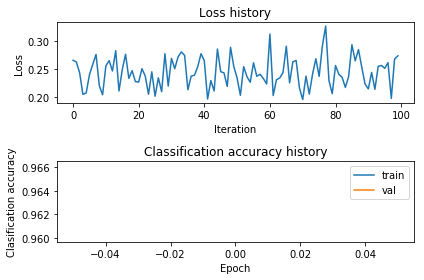

In [14]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend(loc='best')
plt.tight_layout()

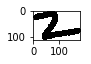

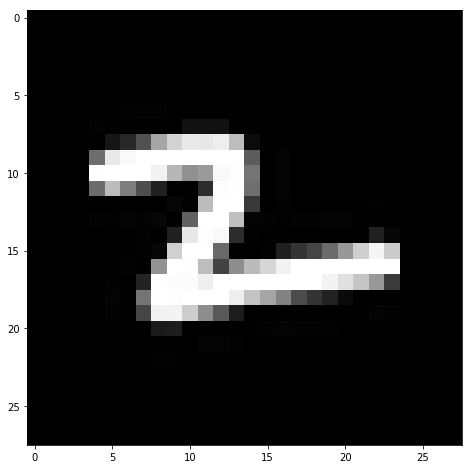

(1, 784)
Label perdicted -> 2


In [27]:
#testing our own data
input_image = "D://2.png"
output = []

l = extract_features(input_image)
for i in l:
    try:
        plt.imshow(i.astype('uint8'),cmap='gray')
        plt.show()
        t = np.array(i)
        t = t.reshape(1,-1).astype(float)
        print(t.shape)
        t = net.predict(t)
        output.append(t[0])
        print('Label perdicted ->',t[0])
    except:
        pass

Input Image is :


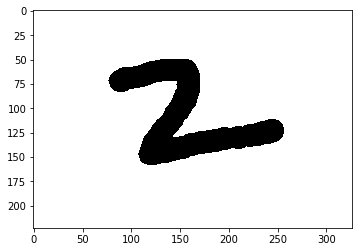

Perdicted Label is : 2 


In [8]:
print('Input Image is :')
plt.imshow(Image.open(input_image))
plt.show()
out = ''
for i in output:
    out += str(i)+' '
print("Perdicted Label is :",out)

In [17]:
from tkinter import Tk, Label, Entry, Button, Canvas, filedialog, Menu
from tkinter import messagebox

class mouse:
	def __init__(self):
		self.xx,self.yy = [],[]
	def motion(self,event):
		#print("Mouse position: (%s %s)" % (event.x, event.y))
		w.create_oval(event.x, event.y,event.x+14, event.y+14,fill = 'black',width=10)
		self.xx.append(event.x)
		self.yy.append(event.y)
	def getp(self):
		return self.xx,self.yy
	def resetp(self):
		self.xx,self.yy = [],[]

def save_image(x,y):
    #y = np.array(y)
    #y = max(y)-y
    #plt.xticks([i for i in range(1000,1,-25)])
    #plt.yticks([i for i in range(1000,1,-25)])
    plt.ylim(300,1)
    plt.xlim(1,300)
    plt.plot(x,y,linewidth=10)
    plt.show()

    # make an agg figure
    fig, ax = plt.subplots()
    plt.ylim(300,1)
    plt.xlim(1,300)
    ax.plot(x,y,linewidth=10)
    fig.canvas.draw()
    # grab the pixel buffer and dump it into a numpy array
    X = np.array(fig.canvas.renderer._renderer)
    # now display the array X as an Axes in a new figure
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, frameon=False)
    ax2.imshow(X)
    #plt.axis('off')
    #plt.grid(False)
    #plt.show()
    im = Image.fromarray(X)
    im = im.convert('L')
    #plt.imshow(im)
    #plt.show()
    arr = np.asarray(im)
    #print(arr.shape)
    arr2 = arr[40:-40,60:-50]
    #arr2.shape
    im = Image.fromarray(arr2)
    plt.imshow(im)
    plt.axis('off')
    plt.grid(False)
    plt.show()
    im = Image.fromarray(arr2)
    im.save("imm.jpg")
    
def exit():
    res = messagebox.askyesno('Exit','Are you Sure')
    if res:
        window.destroy()
def clear():
    w.delete("all")
    c.resetp()
#def open_file():
#    file = filedialog.askopenfilename(filetypes = (("jpg","*.jpg"),("all files","*.*")))
    
def perdict():
    x,y = c.getp()
    if x[:] == [] or y[:] == []:
        res = messagebox.showerror('Error','Please Draw an Image')
    else:
        save_image(x,y)
        input_image = "imm.jpg"
        output = []
        l = extract_features(input_image)
        for i in l:
            try:
                plt.imshow(i.astype('uint8'),cmap='gray')
                plt.show()
                t = np.array(i)
                t = t.reshape(1,-1).astype(float)
                print(t.shape)
                t = net.predict(t)
                output.append(t[0])
                print('Label perdicted ->',t[0])
            except:
                pass
        res = messagebox.showinfo('Label','Label Perdicted is: '+str(t[0]))
    c.resetp()
    return x,y

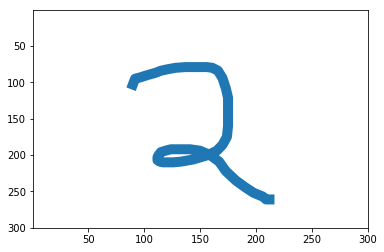

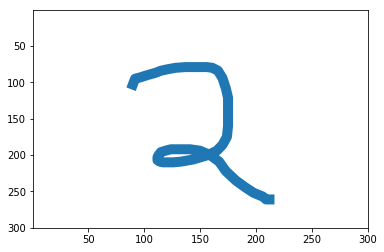

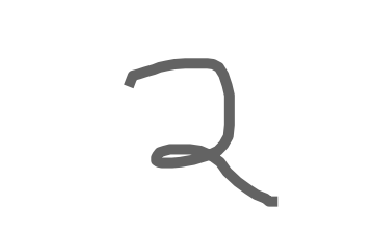

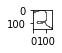

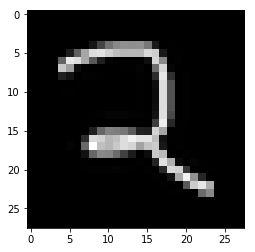

(1, 784)
Label perdicted -> 2


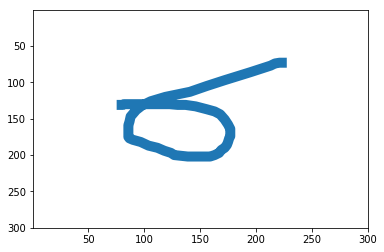

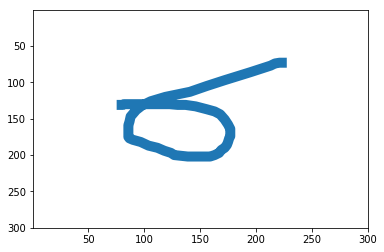

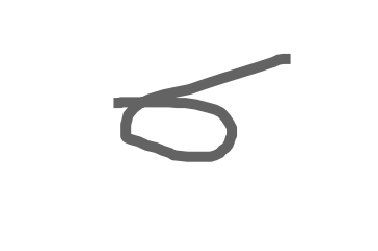

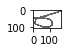

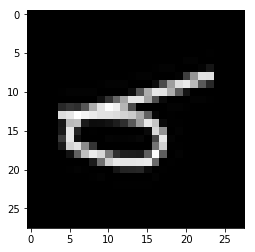

(1, 784)
Label perdicted -> 5


In [20]:
window = Tk()
window.title("Handwritten Character Recognition")
#window.config(width=1080//2, height= 720//2, bg="white")
#window.geometry('1080x720')
c = mouse()
lbl = Label(window, text="Draw Digit", font=("Arial Bold", 20))
lbl.grid(row=0)
lbl2 = Label(window, text=" ", font=("Arial Bold", 10))
lbl2.grid(row=4,column= 0)

#menu = Menu(window)
#new_item = Menu(menu)
#new_item.add_command(label='Open File',command=open_file)
#menu.add_cascade(label='File', menu=new_item)
#window.config(menu=menu)

w = Canvas(window, width=300, height=300, bg="white")
w.config(bg='white')
w.bind('<B1-Motion>',c.motion)
w.grid(row=1,column= 0)

btn = Button(window, text="Exit", bg="orange", fg="red",command=exit)
btn.grid(row=3,column= 0,sticky= 'E',padx=15,ipadx=10)
btn = Button(window, text="Clear Canvas", bg="orange", fg="red",command=clear)
btn.grid(row=3,column= 0,sticky='W',padx=15,ipadx=10)
btn = Button(window, text="Perdict Label", bg="orange", fg="red",command=perdict)
btn.grid(row=2,column= 0,sticky='S,E,N,W',padx=15,pady=15)

window.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Anacoda\lib\site-packages\PIL\Image.py", line 2613, in open
    fp.seek(0)
AttributeError: 'str' object has no attribute 'seek'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anacoda\lib\tkinter\__init__.py", line 1702, in __call__
    return self.func(*args)
  File "<ipython-input-68-f328f661007a>", line 123, in open_file
    images = Image.open(self.file)
  File "C:\Anacoda\lib\site-packages\PIL\Image.py", line 2615, in open
    fp = io.BytesIO(fp.read())
AttributeError: 'str' object has no attribute 'read'


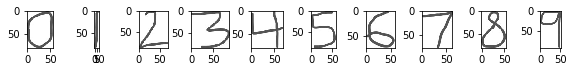

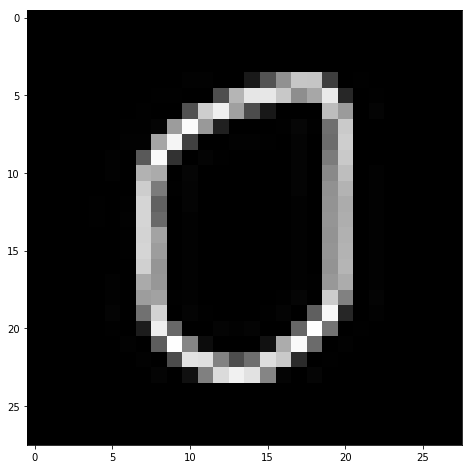

(1, 784)
Label perdicted -> 0


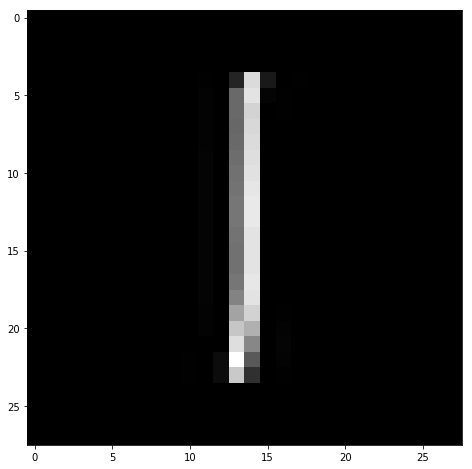

(1, 784)
Label perdicted -> 1


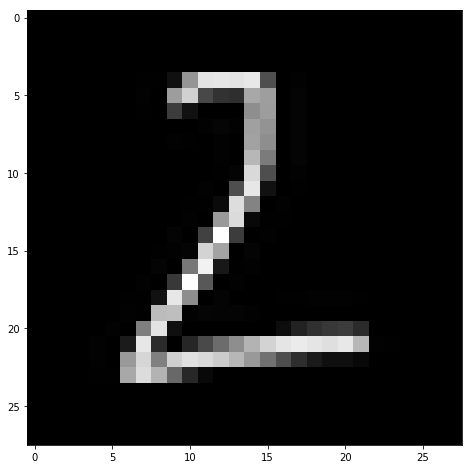

(1, 784)
Label perdicted -> 2


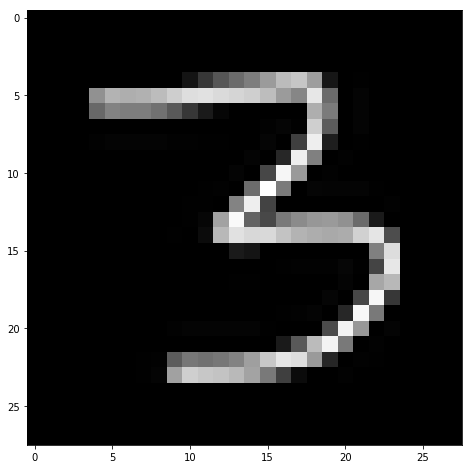

(1, 784)
Label perdicted -> 3


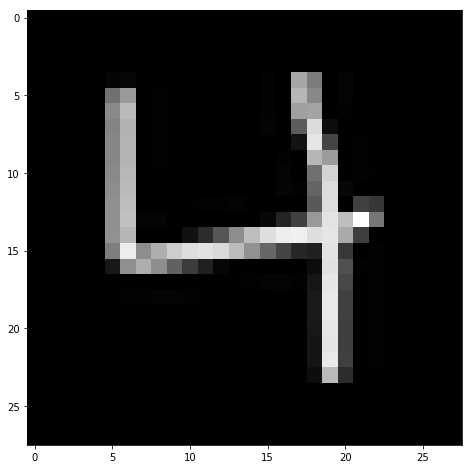

(1, 784)
Label perdicted -> 4


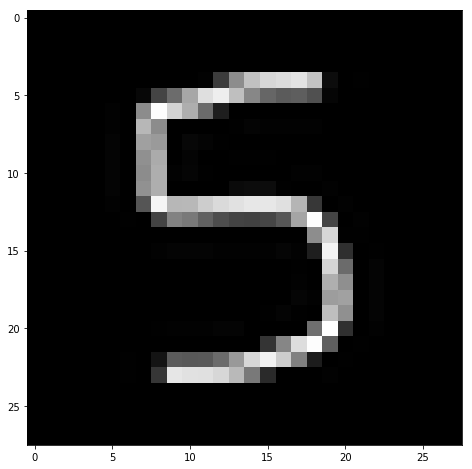

(1, 784)
Label perdicted -> 5


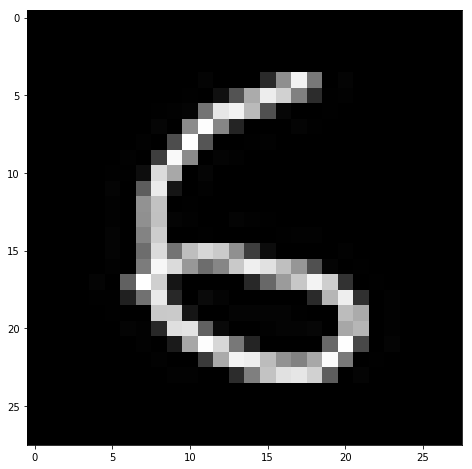

(1, 784)
Label perdicted -> 6


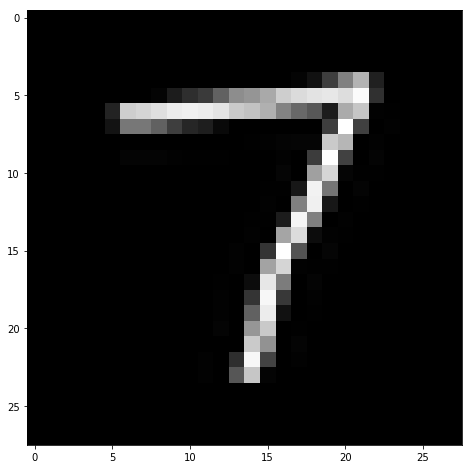

(1, 784)
Label perdicted -> 7


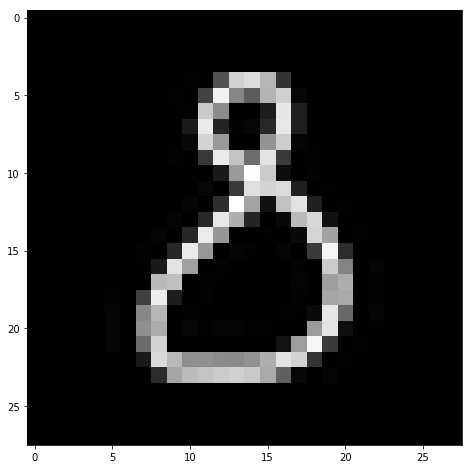

(1, 784)
Label perdicted -> 8


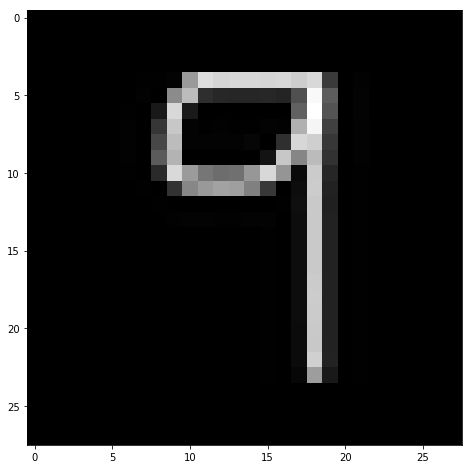

(1, 784)
Label perdicted -> 9


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Anacoda\lib\site-packages\PIL\Image.py", line 2613, in open
    fp.seek(0)
AttributeError: 'str' object has no attribute 'seek'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anacoda\lib\tkinter\__init__.py", line 1702, in __call__
    return self.func(*args)
  File "<ipython-input-68-f328f661007a>", line 123, in open_file
    images = Image.open(self.file)
  File "C:\Anacoda\lib\site-packages\PIL\Image.py", line 2615, in open
    fp = io.BytesIO(fp.read())
AttributeError: 'str' object has no attribute 'read'
Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Anacoda\lib\site-packages\PIL\Image.py", line 2613, in open
    fp.seek(0)
AttributeError: 'str' object has no attribute 'seek'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anacoda\lib\tkinter\

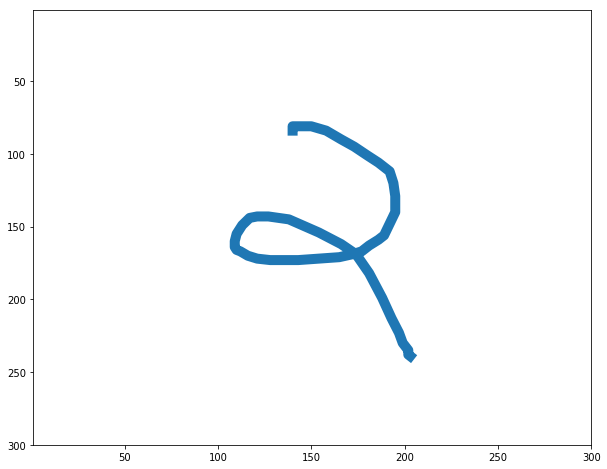

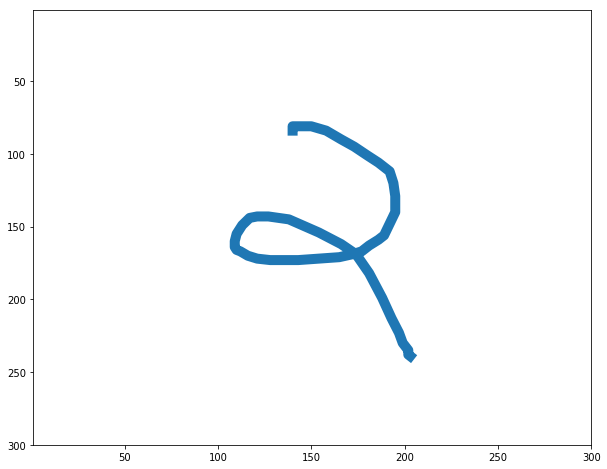

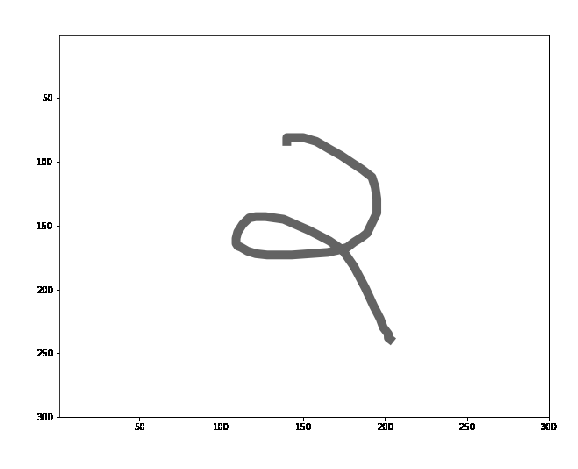

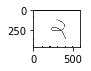

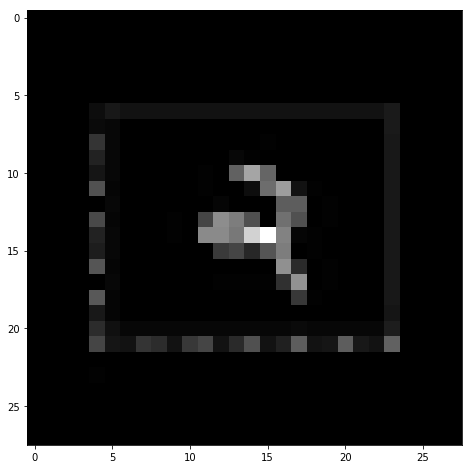

(1, 784)
Label perdicted -> 3


In [68]:
from tkinter import Tk, Label, Entry, Button, Canvas, filedialog ,Menu, messagebox
import tkinter 
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL.Image, PIL.ImageTk
from PIL import Image, ImageTk

class editor:
    def __init__(self):
        self.root = Tk()
        self.root.title("Handwritten Character Recognition")
        self.xx,self.yy = [],[]
        self.file = None
    def save_image(self,x,y):
        plt.ylim(300,1)
        plt.xlim(1,300)
        plt.plot(x,y,linewidth=10)
        plt.show()
        # make an agg figure
        fig, ax = plt.subplots()
        plt.ylim(300,1)
        plt.xlim(1,300)
        ax.plot(x,y,linewidth=10)
        fig.canvas.draw()
        # grab the pixel buffer and dump it into a numpy array
        X = np.array(fig.canvas.renderer._renderer)
        # now display the array X as an Axes in a new figure
        fig2 = plt.figure()
        ax2 = fig2.add_subplot(111, frameon=False)
        im = Image.fromarray(X)
        im = im.convert('L')
        arr = np.asarray(im)
        arr2 = arr[40:-40,60:-50]
        im = Image.fromarray(arr2)
        plt.imshow(im)
        plt.axis('off')
        plt.grid(False)
        plt.show()
        im = Image.fromarray(arr2)
        im.save("imm.jpg")
    def motion(self,event):
        #print("Mouse position: (%s %s)" % (event.x, event.y))
        self.can.create_oval(event.x, event.y,event.x+14, event.y+14,fill = 'black',width=10)
        self.xx.append(event.x)
        self.yy.append(event.y)
    def getp(self):
        return self.xx,self.yy
    def resetp(self):
        self.xx,self.yy = [],[]
    def get_label(self):
        return 4
    def exit(self):
        res = messagebox.askyesno('Exit','Are you Sure')
        if res:
            self.root.destroy()
    def clear(self):
        self.can.delete("all")
        self.resetp()
        try:
            self.label.destroy()
            self.file = None
        except:pass
    def perdict(self):
        x,y = self.getp()
        if self.file == None and x[:] == []:
            res = messagebox.showerror('Error','Please Draw or Select an Image')
        else:
            if self.file != None:
                input_image = self.file
            else:
                self.save_image(x,y)
                input_image = 'imm.jpg'
            output = []
            l = extract_features(input_image)
            for i in l:
                try:
                    plt.imshow(i.astype('uint8'),cmap='gray')
                    plt.show()
                    t = np.array(i)
                    t = t.reshape(1,-1).astype(float)
                    print(t.shape)
                    t = net.predict(t)
                    output.append(t[0])
                    print('Label perdicted ->',t[0])
                except:
                    pass
            res = messagebox.showinfo('Label','Label Perdicted is: '+str(output[:]))
            self.resetp()
    def labels(self):
        self.lbl = Label(self.root, text="Draw Digit", font=("Arial Bold", 20))
        self.lbl.grid(row=0)
        self.lbl2 = Label(self.root, text=" ", font=("Arial Bold", 10))
        self.lbl2.grid(row=4,column= 0)
    def menus(self):
        menu = Menu(self.root)
        new_item = Menu(menu,tearoff=0)
        new_item.add_command(label='Open File',command = self.open_file)
        menu.add_cascade(label='File', menu = new_item)
        self.root.config(menu=menu)
    def canvases(self):
        self.can = Canvas(self.root, width=300, height=300, bg="white")
        self.can.config(bg='white')
        self.can.bind('<B1-Motion>',self.motion)
        self.can.grid(row=1,column= 0)        
    def buttons(self):
        self.btn = Button(self.root, text="Exit", bg="orange", fg="red",command=self.exit)
        self.btn.grid(row=3,column= 0,sticky= 'E',padx=15,ipadx=10)
        self.btn = Button(self.root, text="Clear Canvas", bg="orange", fg="red",command=self.clear)
        self.btn.grid(row=3,column= 0,sticky= 'W',padx=15,ipadx=10)
        self.btn = Button(self.root, text="Perdict Label", bg="orange", fg="red",command=self.perdict)
        self.btn.grid(row=2,column= 0,sticky='S,N,E,W',padx=15,pady=15)
    def run(self):
        self.labels()
        self.menus()
        self.canvases()
        self.buttons()
        self.root.mainloop()
    def open_file(self):
        self.file = filedialog.askopenfilename(filetypes = (("jpg","*.jpg"),("all files","*.*")))
        if self.file:
            self.can.delete("all")
        images = Image.open(self.file)
        #images= images.resize((640, 480), PIL.Image.ANTIALIAS)
        img = ImageTk.PhotoImage(images)
        self.label = Label(self.root, image=img)
        self.label.img = img
        self.label.grid(column=0,row=1)
edit = editor()
edit.run()